Experiment A2: Activation Patching with Counterfactuals

Same setup as A1
TODO: record adversarial label to test label correctness

https://nnsight.net/notebooks/tutorials/activation_patching/

In [18]:
import nnsight
from nnsight import NNsight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

from robustness import model_utils
from robustness.datasets import CIFAR

import torchvision.transforms as transforms
import torchvision
from PIL import Image

import os
import sys
from tqdm import tqdm

# Add the parent directory to the path to import custom modules
sys.path.append(os.path.abspath(os.path.join('..')))
from models.resnet import ResNet18
from adversarial.utils import load_dataset  



In [6]:
# load saved model
datapath = '/u/yshi23/distribution-shift/datasets'
model_pth = "/u/yshi23/distribution-shift/adversarial/verify/best_model.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = ResNet18(num_classes=10)
checkpoint = torch.load(model_pth, map_location=device)
state_dict = checkpoint

# Load the modified state dict with strict=False to ignore missing/unexpected keys
model.load_state_dict(checkpoint, strict=False)

print("Model loaded successfully on", device)

Model loaded successfully on cuda:0


In [20]:
def test(model, loader, device: str = "cuda:0"):
    # do some sanity check to ensure typing is correct
    assert isinstance(model, nn.Module)
    assert isinstance(loader, DataLoader)
    # set model to evaluation mode
    model.eval()
    # move model to device
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only expect a single output
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # compute and return accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy on test set is {accuracy}")
    return accuracy


In [21]:
# test the model as a sanity check, on cifar10 testset
_, _, testloader = load_dataset(datapath)

# load cifar10 testset through torchvision
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.25, 0.25, 0.25),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader_orig = DataLoader(trainset, batch_size=64, shuffle=True)
testloader_orig = DataLoader(testset, batch_size=64, shuffle=False)


print("Testing on robustness CIFAR10 testset")
test(model, testloader)

print("Testing on torchvision CIFAR10 testset")
test(model, testloader_orig)

Successfully loaded data loaders
Testing on robustness CIFAR10 testset


100%|██████████| 79/79 [00:09<00:00,  7.90it/s]


Accuracy on test set is 35.56
Testing on torchvision CIFAR10 testset


100%|██████████| 157/157 [00:10<00:00, 14.98it/s]

Accuracy on test set is 87.98


87.98

In [6]:
def load_cifar10_image(image_path):
    # Load the image
    img = Image.open(image_path).convert("RGB")

    # Define the transforms that match ResNet18 expectations
    transform = transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),  # Must be before Normalize
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    # Apply transformations
    img_tensor = transform(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)  # Shape: [1, 3, 32, 32]

    return img_tensor


# Usage example
orig_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/natural_image_0.png"
clean_img = load_cifar10_image(orig_path)

low_ep_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/adv_image_small_epsilon_0.png"
low_eps_img = load_cifar10_image(low_ep_path)

high_ep_path = "/u/yshi23/distribution-shift/adversarial/visualizations/phoebe_visualizations/adv_image_large_epsilon_0.png"
high_eps_img = load_cifar10_image(high_ep_path)

In [ ]:
def load_cifar10_data(pt_path):
    # Load the CIFAR-10 dataset of generated adversarial paths into a DataLoader
    # paths have data.pt and labels.pt
    data = torch.load(f"{pt_path}/data.pt")
    labels = torch.load(f"{pt_path}/labels.pt")
    dataset = torch.utils.data.TensorDataset(data, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    return dataloader

def load_all_perturbations(pt_folder):
    # iterate through all pt paths in the folder
    # load the data and labels
    # return dict of subfolder name to dataloader
    pt_folder = "/u/yshi23/distribution-shift/adversarial/path_to_save"
    # get subfolders
    subfolders = [f for f in os.scandir(pt_folder) if f.is_dir()]
    dataloader_dict = {}
    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder.path)
        dataloader = load_cifar10_data(subfolder.path)
        dataloader_dict[subfolder_name] = dataloader
    return dataloader_dict

perturbations_dict = load_all_perturbations("/u/yshi23/distribution-shift/adversarial/path_to_save")
print(perturbations_dict.keys())


In [7]:
# Get all layer names (keys) from the model's state dictionary
layer_names = list(model.state_dict().keys())

# Print all layer names
print("Model layer names:")
for name in layer_names:
    print(name)

Model layer names:
conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.shortcut.0.weight


In [8]:
nnsight_model = NNsight(model)

In [ ]:
import matplotlib.pyplot as plt

LAYER_NAMES = [
    "conv1",
    "layer1",
    "layer2.0.shortcut.0",
    "layer2.0.shortcut.1",
    "layer2",
    "layer3.0.shortcut.0",
    "layer3.0.shortcut.1",
    "layer3",
    "layer4.0.shortcut.0",
    "layer4.0.shortcut.1",
    "layer4",
    "linear",
]


def get_nested_module(model, name):
    """Recursively navigate dot-separated paths including numeric indexes."""
    parts = name.split(".")
    for part in parts:
        if part.isdigit():
            model = model[int(part)]
        else:
            model = getattr(model, part)
    return model


def collect_adversarial_activations(nnsight_model, adversarial_img):
    """Trace and collect activations for each layer from an adversarial image."""
    with nnsight_model.trace(adversarial_img):
        return {
            name: get_nested_module(nnsight_model, name).output.save()
            for name in LAYER_NAMES
        }


def test_adversarial_activations(nnsight_model, clean_img, adv_activations):
    """
    Inject adversarial activations into clean input at each layer and save final output.
    """
    output_results = []

    for name in LAYER_NAMES:
        layer = get_nested_module(nnsight_model, name)
        with nnsight_model.trace(clean_img):
            layer.output = adv_activations[name]
            final_output = nnsight_model.linear.output.save()
        output_results.append({"layer_name": name, "output": final_output})

    return output_results


def get_clean_baseline(nnsight_model, clean_img):
    """Get the output of the model for a clean input."""
    with nnsight_model.trace(clean_img):
        return nnsight_model.linear.output.save()

def get_adv_baseline(nnsight_model, adv_img):
    """Get the output of the model for an adversarial input."""
    with nnsight_model.trace(adv_img):
        return nnsight_model.linear.output.save()

def plot_confidence_difference(
    output_results, clean_baseline, adv_baseline, idx1, idx2, title="Confidence Difference Heatmap"
):
    """
    Plot class confidence differences (idx1 - idx2) with and without adversarial injections.
    """
    x_labels = ["clean base"] + ["adv base"] + [r["layer_name"] for r in output_results]

    def get_diff(logits):
        logits = logits.detach().cpu().numpy()[0]
        return logits[idx1] - logits[idx2]

    differences = [get_diff(clean_baseline)] + [get_diff(adv_baseline)] + [
        get_diff(r["output"]) for r in output_results
    ]

    plt.figure(figsize=(12, 4))
    plt.imshow([differences], cmap="RdBu_r", aspect="auto")
    plt.colorbar(label=f"Confidence Difference (class {idx1} - class {idx2})")
    plt.yticks([])
    plt.xticks(range(len(x_labels)), x_labels, rotation=45)
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()


def analyze_adversarial_effects(nnsight_model, clean_img, adversarial_img):
    """
    Full pipeline: collect adversarial features, inject at each layer, plot effects.
    """
    print("Collecting adversarial activations...")
    adv_activations = collect_adversarial_activations(nnsight_model, adversarial_img)

    print("Getting clean baseline...")
    clean_baseline = get_clean_baseline(nnsight_model, clean_img)

    print("Getting adversarial baseline...")
    adv_baseline = get_adv_baseline(nnsight_model, adversarial_img)

    clean_label = torch.argmax(clean_baseline)
    adv_label = torch.argmax(adv_baseline)

    print(f"Clean label: {clean_label}, Adversarial label: {adv_label}")

    print("Testing adversarial activations at each layer...")
    output_results = test_adversarial_activations(
        nnsight_model, clean_img, adv_activations
    )

    print("Plotting confidence difference...")
    fig = plot_confidence_difference(
        output_results,
        clean_baseline,
        adv_baseline,
        clean_label,
        adv_label,
        title=f"Confidence Gap Between Clean and Adversarial Labels",
    )

    plt.show()

    return {
        "clean_baseline": clean_baseline,
        "adv_baseline": adv_baseline,
        "layer_results": output_results,
        "figure": fig,
    }

Getting clean baseline...
Getting adversarial baseline...
Clean label: 2, Adversarial label: 2
Testing adversarial activations at each layer...
Plotting confidence difference...


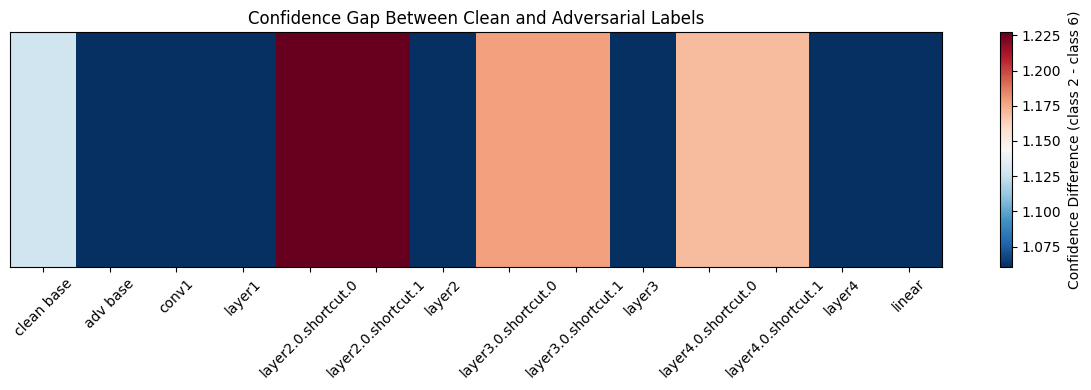

{'clean_baseline': tensor([[-0.0752, -0.4136,  1.3230,  0.4147, -0.1154, -0.6176,  0.1961, -0.8348,
          -0.2443, -0.3907]], grad_fn=<AddmmBackward0>),
 'adv_baseline': tensor([[ 0.0271, -0.4164,  1.2182,  0.3810, -0.1435, -0.6388,  0.1577, -0.8999,
          -0.2427, -0.4062]], grad_fn=<AddmmBackward0>),
 'layer_results': [{'layer_name': 'conv1',
   'output': tensor([[ 0.0271, -0.4164,  1.2182,  0.3810, -0.1435, -0.6388,  0.1577, -0.8999,
            -0.2427, -0.4062]], grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer1',
   'output': tensor([[ 0.0271, -0.4164,  1.2182,  0.3810, -0.1435, -0.6388,  0.1577, -0.8999,
            -0.2427, -0.4062]], grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer2.0.shortcut.0',
   'output': tensor([[-0.0827, -0.3531,  1.3191,  0.3684, -0.1296, -0.6037,  0.0919, -0.8716,
            -0.2671, -0.4430]], grad_fn=<AddmmBackward0>)},
  {'layer_name': 'layer2.0.shortcut.1',
   'output': tensor([[-0.0827, -0.3531,  1.3191,  0.3684, -0.1296, -0.6037, 

In [10]:
# labels for base, low, high: 2, 4, 6 (auto, deer, frog)
analyze_adversarial_effects(
    nnsight_model,
    clean_img,
    high_eps_img,
)

In [ ]:
# alternative signal:
# First trace
with nnsight_model.trace(clean_img) as tracer:
    clean_out = nnsight_model.linear.output.save() # just care about confidence / probs 

with nnsight_model.trace(high_eps_img) as tracer:
    conv1_out = nnsight_model.conv1.output.save()
    layer1_out = nnsight_model.layer1.output.save()
    layer2_out = nnsight_model.layer2.output.save()
    layer3_out = nnsight_model.layer3.output.save()
    layer4_out = nnsight_model.layer4.output.save()

#  patching loop
# loop through captured high eps outputs, patch in at respective time, take difference between clean_out and patch_out(clean_img) 

In [21]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def _save_main_layers(model):
    return {
        "conv1": model.conv1.output.save(),
        "bn1": model.bn1.output.save(),
        "layer1": model.layer1.output.save(),
        "layer2": model.layer2.output.save(),
        "layer3": model.layer3.output.save(),
        "layer4": model.layer4.output.save(),
        "linear": model.linear.output.save(),
    }


def _save_block_outputs(layer, prefix):
    return {f"{prefix}.block{i}": block.output.save() for i, block in enumerate(layer)}


def _compute_diffs(clean_act, adv_act):
    return {
        "mean": torch.mean(torch.abs(adv_act - clean_act)).item(),
        "max": torch.max(torch.abs(adv_act - clean_act)).item(),
    }


def visualize_activation_differences(model, clean_img, adv_img):
    """
    Visualize differences in activations between clean and adversarial images
    across all layers of a ResNet model.
    """
    diffs = {}

    # Trace clean image
    with model.trace(clean_img):
        clean_main = _save_main_layers(model)
        clean_blocks = {
            **_save_block_outputs(model.layer1, "layer1"),
            **_save_block_outputs(model.layer2, "layer2"),
            **_save_block_outputs(model.layer3, "layer3"),
            **_save_block_outputs(model.layer4, "layer4"),
        }

    # Trace adversarial image
    with model.trace(adv_img):
        adv_main = _save_main_layers(model)
        adv_blocks = {
            **_save_block_outputs(model.layer1, "layer1"),
            **_save_block_outputs(model.layer2, "layer2"),
            **_save_block_outputs(model.layer3, "layer3"),
            **_save_block_outputs(model.layer4, "layer4"),
        }

    # Compute diffs for main layers
    for name in clean_main:
        diffs[name] = _compute_diffs(clean_main[name], adv_main[name])

    # Compute diffs for residual blocks
    for name in clean_blocks:
        diffs[name] = _compute_diffs(clean_blocks[name], adv_blocks[name])

    # Create a DataFrame for plotting
    df = pd.DataFrame.from_dict(diffs, orient="index").reset_index()
    df.columns = ["Layer", "Mean Absolute Difference", "Max Absolute Difference"]

    # Sorting logic based on hierarchical naming
    def get_sort_index(layer_name):
        parts = layer_name.split(".")
        if layer_name.startswith("conv1"):
            return 0
        elif layer_name.startswith("bn1"):
            return 1
        elif layer_name.startswith("relu"):
            return 2
        elif layer_name.startswith("maxpool"):
            return 3
        elif "layer" in parts[0]:
            layer_num = int(parts[0][-1])
            block_num = int(parts[1][-1]) if len(parts) > 1 else -1
            return 4 + layer_num * 10 + (block_num + 1 if block_num >= 0 else 0)
        elif layer_name.startswith("avgpool"):
            return 100
        elif layer_name.startswith("linear"):
            return 101
        return 999  # fallback

    df["SortIdx"] = df["Layer"].apply(get_sort_index)
    df = df.sort_values("SortIdx")

    # Plot
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    sns.barplot(x="Layer", y="Mean Absolute Difference", data=df)
    plt.xticks(rotation=90)
    plt.title(
        "Mean Absolute Activation Differences Between Clean and Adversarial Images"
    )

    plt.subplot(2, 1, 2)
    sns.barplot(x="Layer", y="Max Absolute Difference", data=df)
    plt.xticks(rotation=90)
    plt.title(
        "Maximum Absolute Activation Differences Between Clean and Adversarial Images"
    )

    plt.tight_layout()
    plt.savefig("activation_differences.png")
    plt.show()

    return df

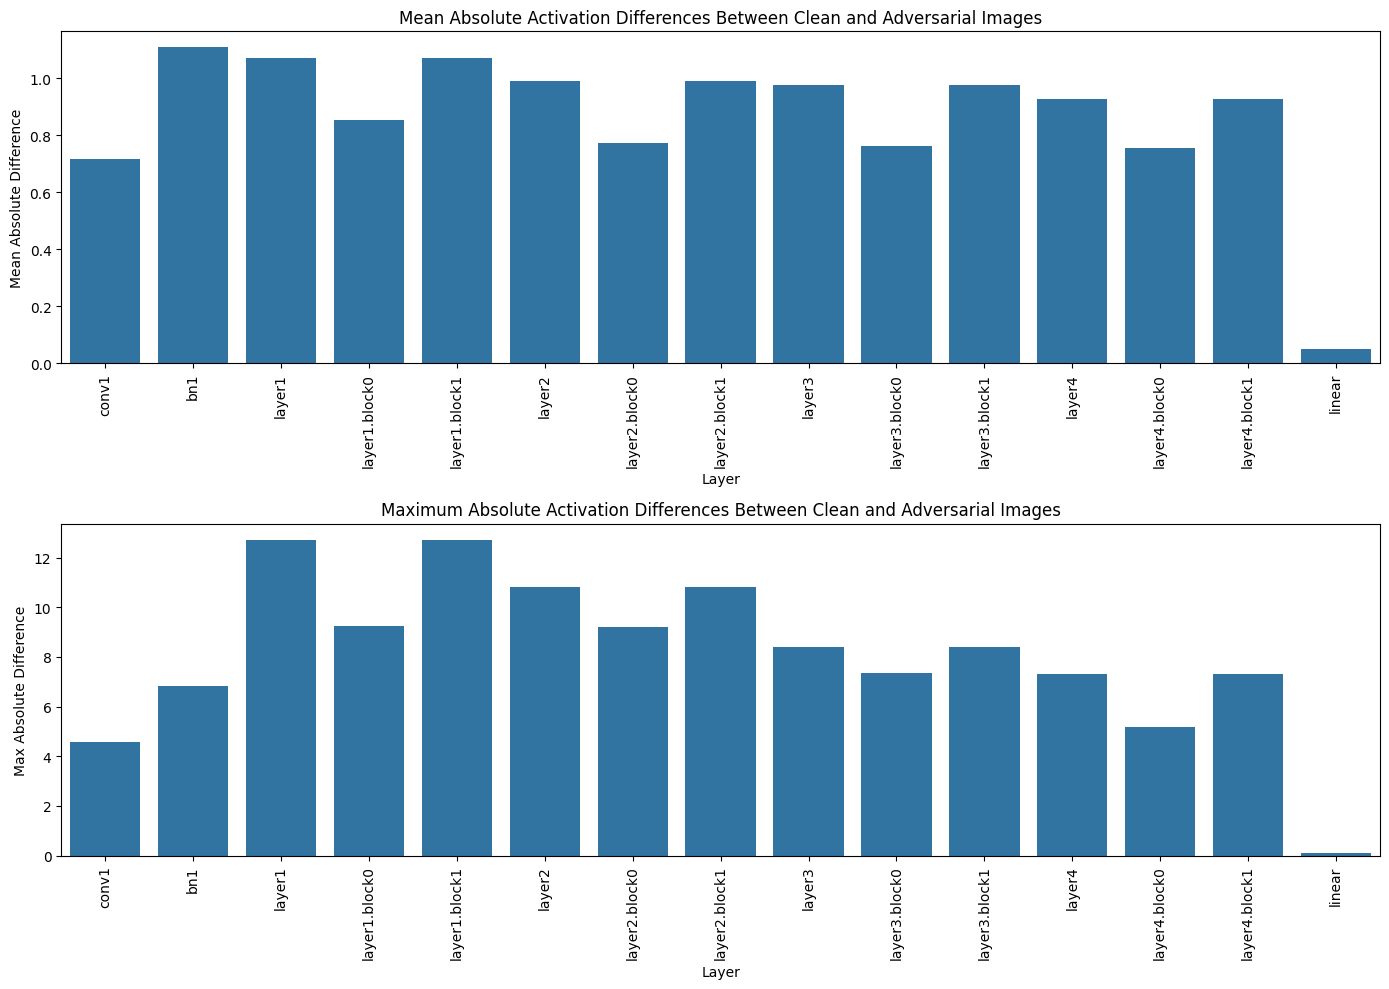

,Layer,Mean Absolute Difference,Max Absolute Difference,SortIdx
0,conv1,0.718119,4.569898,0
1,bn1,1.109219,6.820585,1
2,layer1,1.071224,12.724138,14
7,layer1.block0,0.852682,9.256755,15
8,layer1.block1,1.071224,12.724138,16
3,layer2,0.991933,10.808463,24
9,layer2.block0,0.771806,9.201981,25
10,layer2.block1,0.991933,10.808463,26
4,layer3,0.974906,8.397552,34
11,layer3.block0,0.763218,7.359338,35


In [19]:
visualize_activation_differences(nnsight_model, clean_img, high_eps_img)